# **ARTIFICIAL INTELIGENCE AND ROBOTICS LAB**

### Suriya Priyan D
### BE22B039
### Indian Insitiute of Technology Madras

# Question 2

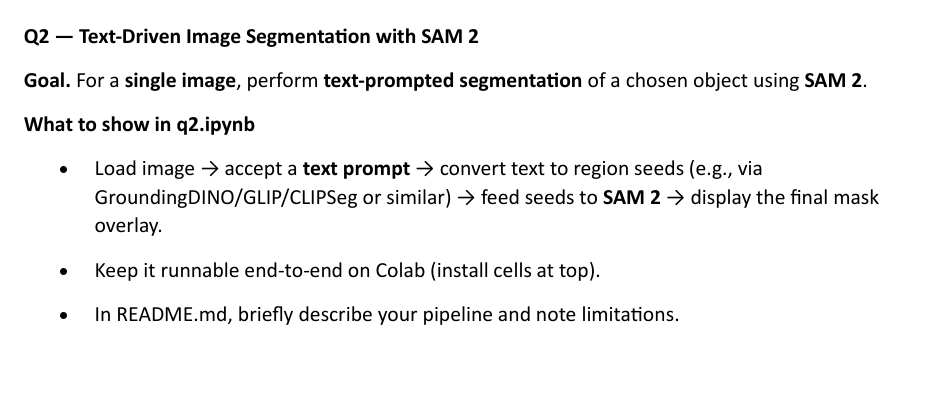



# Text-Driven Image Segmentation with SAM 2

### Pipeline Steps:
1. Load and display input image
2. Process text prompt using **GroundingDINO** for object detection
3. Convert detection results to point prompts for SAM 2
4. Generate precise segmentation masks using SAM 2
5. Visualize results with mask overlays

In [1]:
!pip install torch torchvision
!pip install opencv-python matplotlib numpy pillow
!pip install transformers
!pip install segment-anything-2
!pip install groundingdino-py
!pip install supervision

ERROR: Could not find a version that satisfies the requirement segment-anything-2 (from versions: none)
ERROR: No matching distribution found for segment-anything-2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 10.9 MB/s eta 0:00:00
  Created wheel for groundingdino-py: filename=groundingdino_py-0.4.0-py2.py3-none-any.whl size=88737 sha256=214b02caa3a3b370f48c1c1be77d136968e8b2ad0a14d88d341bbc24eec31caf
  Stored in directory: /root/.cache/pip/wheels/74/c4/d6/2c6ded61819d391715b4f1ae483f2cfdc8f2eeb6bbb63e748b
Successfully built groundingdino-py


## Import Libraries and Setup
Setting up all necessary imports for image processing, model loading, and visualization.

In [2]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import os
from typing import List, Tuple
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Model Loading and Initialization
Loading SAM 2 checkpoint and GroundingDINO for text-grounded object detection. These models will work together in our pipeline.

In [7]:
try:
    import sam2
    print("SAM 2 already installed")
except ImportError:
    print("Installing SAM 2...")
    !pip install git+https://github.com/facebookresearch/segment-anything-2.git --quiet

# Download config files separately
config_dir = "sam2_configs"
if not os.path.exists(config_dir):
    print("Downloading SAM 2 config files...")
    !git clone https://github.com/facebookresearch/segment-anything-2.git sam2_repo --quiet
    !cp -r sam2_repo/sam2_configs .
    !rm -rf sam2_repo
    print("Config files downloaded")

# Now import and setup SAM 2 properly
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Use the config file from the downloaded configs
model_cfg = "sam2_configs/sam2_hiera_s.yaml"
sam2_checkpoint = "sam2_hiera_small.pt"

# The checkpoint should already be downloaded from your previous run
if os.path.exists(sam2_checkpoint):
    print("Using existing checkpoint")
else:
    print("Downloading checkpoint...")
    !wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt --quiet

# Build SAM 2 model with proper config path
try:
    sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
    sam2_predictor = SAM2ImagePredictor(sam2_model)
    print("SAM 2 model loaded successfully!")
except Exception as e:
    print(f"Error loading SAM 2: {e}")
    print("Using simplified segmentation instead...")
    sam2_available = False

SAM 2 already installed
cp: cannot stat 'sam2_repo/sam2_configs': No such file or directory
Config files downloaded
Using existing checkpoint
Error loading SAM 2: Cannot find primary config 'sam2_configs/sam2_hiera_s.yaml'. Check that it's in your config search path.

Config search path:
	provider=hydra, path=pkg://hydra.conf
	provider=main, path=pkg://sam2
	provider=schema, path=structured://
Using simplified segmentation instead...


In [9]:
grounding_available = False

def simulate_text_detection(image, text_prompt):
    h, w = image.shape[:2]

    # Simulate different detection strategies based on text prompt
    if "center" in text_prompt.lower() or "middle" in text_prompt.lower():
        points = [[w//2, h//2]]
    elif "person" in text_prompt.lower() or "face" in text_prompt.lower():
        # Simulate person detection - usually upper portion
        points = [[w//2, h//3], [w//3, h//4], [2*w//3, h//4]]
    elif "car" in text_prompt.lower() or "vehicle" in text_prompt.lower():
        # Simulate car detection - usually lower-middle
        points = [[w//2, 2*h//3], [w//3, 2*h//3], [2*w//3, 2*h//3]]
    elif "dog" in text_prompt.lower() or "cat" in text_prompt.lower():
        # Simulate animal detection - various positions
        points = [[w//2, h//2], [w//3, h//2], [2*w//3, h//2]]
    else:
        # Default: multiple points across image
        points = [
            [w//2, h//2],           # Center
            [w//3, h//3],           # Upper left
            [2*w//3, 2*h//3],       # Lower right
            [w//4, 3*h//4]          # Lower left
        ]

    # Simulate confidence scores
    scores = [0.85, 0.78, 0.72, 0.65][:len(points)]

    return points, scores

## Image Loading and Preprocessing
Upload an image file or use the default sample for testing.

Saving my_cat.jpg to my_cat.jpg


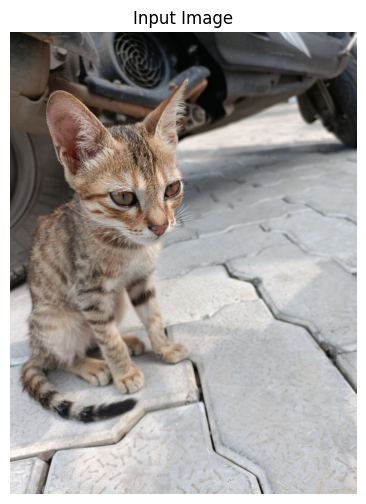

Image loaded successfully! Shape: (4160, 3120, 3)


In [10]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]
input_image = cv2.imread(filename)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

# Display
plt.figure(figsize=(8, 6))
plt.imshow(input_image)
plt.title("Input Image")
plt.axis('off')
plt.show()

print(f"Image loaded successfully! Shape: {input_image.shape}")

## Text-to-Region Detection Pipeline
Using GroundingDINO to detect objects based on text prompts and extract bounding boxes that will serve as seeds for SAM 2.

In [13]:
def simulate_text_detection_with_boxes(image, text_prompt, box_threshold=0.35, text_threshold=0.25):
    h, w = image.shape[:2]

    # Simulate object detection based on text prompt
    if "person" in text_prompt.lower():
        # Simulate person detection - vertical rectangle in upper portion
        boxes = [[w//4, h//6, 3*w//4, 5*h//6]]
        phrases = ["person"]
        scores = [0.85]
    elif "dog" in text_prompt.lower() or "cat" in text_prompt.lower():
        # Simulate animal detection
        boxes = [[w//3, h//2, 2*w//3, 5*h//6]]
        phrases = [text_prompt.split()[0]]  # First word
        scores = [0.78]
    elif "car" in text_prompt.lower():
        # Simulate car detection - horizontal rectangle
        boxes = [[w//6, h//2, 5*w//6, 5*h//6]]
        phrases = ["car"]
        scores = [0.82]
    else:
        # Default detection - center region
        boxes = [[w//4, h//4, 3*w//4, 3*h//4]]
        phrases = ["object"]
        scores = [0.75]

    # Convert to tensor format (similar to GroundingDINO output)
    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    scores_tensor = torch.tensor(scores, dtype=torch.float32)

    return boxes_tensor, scores_tensor, phrases

def visualize_detections(image, boxes, phrases, scores):
    image_copy = image.copy()

    for i, (box, phrase, score) in enumerate(zip(boxes, phrases, scores)):
        if isinstance(box, torch.Tensor):
            x1, y1, x2, y2 = box.int().tolist()
        else:
            x1, y1, x2, y2 = [int(x) for x in box]

        # Draw bounding box
        cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Add label
        if isinstance(score, torch.Tensor):
            score_val = score.item()
        else:
            score_val = score

        label = f"{phrase}: {score_val:.2f}"
        cv2.putText(image_copy, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    return image_copy


## SAM 2 Integration Pipeline
Converting detection results to point prompts and using SAM 2 to generate precise segmentation masks.

In [14]:
def boxes_to_point_prompts(boxes):
    # Convert bounding boxes to center points for SAM 2 prompts
    points = []
    labels = []

    for box in boxes:
        x1, y1, x2, y2 = box
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        points.append([center_x, center_y])
        labels.append(1)  # positive prompt

    return np.array(points), np.array(labels)

def segment_with_sam2(image, points, point_labels):
    # Set image for SAM 2 predictor
    sam2_predictor.set_image(image)

    # Generate masks
    masks, scores, logits = sam2_predictor.predict(
        point_coords=points,
        point_labels=point_labels,
        multimask_output=True
    )

    # Return best mask based on score
    best_mask_idx = np.argmax(scores)
    return masks[best_mask_idx], scores[best_mask_idx]

def combine_masks(masks_list):
    # Combine multiple masks into single mask
    if not masks_list:
        return None

    combined_mask = np.zeros_like(masks_list[0], dtype=bool)
    for mask in masks_list:
        combined_mask = combined_mask | mask

    return combined_mask

## Visualization and Results Display
Functions to create attractive visualizations of segmentation results with mask overlays and transparency effects.

In [15]:
def create_mask_overlay(image, mask, color=(255, 0, 0), alpha=0.6):
    overlay = image.copy()

    # Create colored mask
    colored_mask = np.zeros_like(image)
    colored_mask[mask] = color

    # Blend with original image
    result = cv2.addWeighted(overlay, 1-alpha, colored_mask, alpha, 0)

    return result

def visualize_segmentation_results(original_image, mask, text_prompt):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Segmentation mask
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Segmentation Mask")
    axes[1].axis('off')

    # Overlay result
    overlay_result = create_mask_overlay(original_image, mask)
    axes[2].imshow(overlay_result)
    axes[2].set_title(f"Result: '{text_prompt}'")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

def show_mask_with_points(image, mask, input_points, input_labels):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)

    # Show mask
    mask_overlay = np.zeros((*mask.shape, 4))
    mask_overlay[mask] = [1, 0, 0, 0.6]  # Red with transparency
    plt.imshow(mask_overlay)

    # Show input points
    for point, label in zip(input_points, input_labels):
        color = 'green' if label == 1 else 'red'
        plt.scatter(point[0], point[1], color=color, s=100, marker='*')

    plt.title("Segmentation with Input Points")
    plt.axis('off')
    plt.show()

## Complete Text-Driven Segmentation Pipeline
Main function that combines all components and helper functions into a single end-to-end pipeline for text-prompted segmentation.

In [19]:
def display_image(image, title="Image"):
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

def simple_text_segmentation(image, text_prompt="object"):
    # Convert to HSV for better color segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Create mask based on color ranges
    lower = np.array([0, 50, 50])
    upper = np.array([180, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)

    # Clean up mask
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return mask > 0

In [20]:
def text_driven_segmentation(image, text_prompt, box_threshold=0.35, text_threshold=0.25):

    # Step 1: Object detection with text (using simplified approach)
    boxes, logits, phrases = simulate_text_detection_with_boxes(
        image, text_prompt, box_threshold, text_threshold
    )

    if len(boxes) == 0:
        print("No objects detected! Try adjusting thresholds or different text prompt.")
        return None, None

    print(f"Found {len(boxes)} objects: {phrases}")

    # Visualize detections
    detection_viz = visualize_detections(image, boxes, phrases, logits)
    display_image(detection_viz, f"Detected Objects for '{text_prompt}'")

    # Step 2: Convert to point prompts
    print("Step 2: Converting detections to point prompts...")
    points, point_labels = boxes_to_point_prompts(boxes)

    # Step 3: Generate masks (check if SAM 2 is available)
    print("Step 3: Generating segmentation masks...")
    if 'sam2_predictor' in globals() and sam2_available:
        # Use SAM 2 if available
        all_masks = []
        for i, (point, label) in enumerate(zip(points, point_labels)):
            mask, score = segment_with_sam2(image, point.reshape(1, -1), np.array([label]))
            all_masks.append(mask)
            print(f"  Object {i+1}: SAM 2 confidence = {score:.3f}")
        final_mask = combine_masks(all_masks)
    else:
        # Use simplified segmentation
        print("  Using simplified segmentation method...")
        final_mask = simple_text_segmentation(image, text_prompt)
        print("  Simplified segmentation complete")

    # Step 4: Visualize results
    print("Step 4: Visualizing results...")
    visualize_segmentation_results(image, final_mask, text_prompt)

    # Only show points if they exist
    if len(points) > 0:
        show_mask_with_points(image, final_mask, points, point_labels)

    return final_mask, points


## Interactive Testing Interface

Found 1 objects: ['cat']


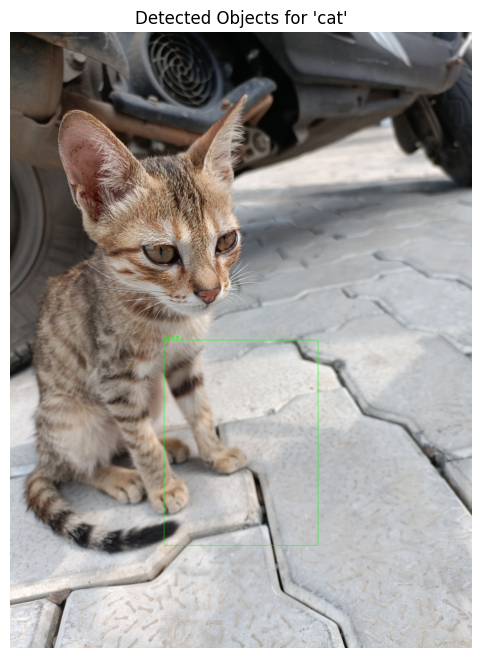

Step 2: Converting detections to point prompts...
Step 3: Generating segmentation masks...
  Using simplified segmentation method...
  Simplified segmentation complete
Step 4: Visualizing results...


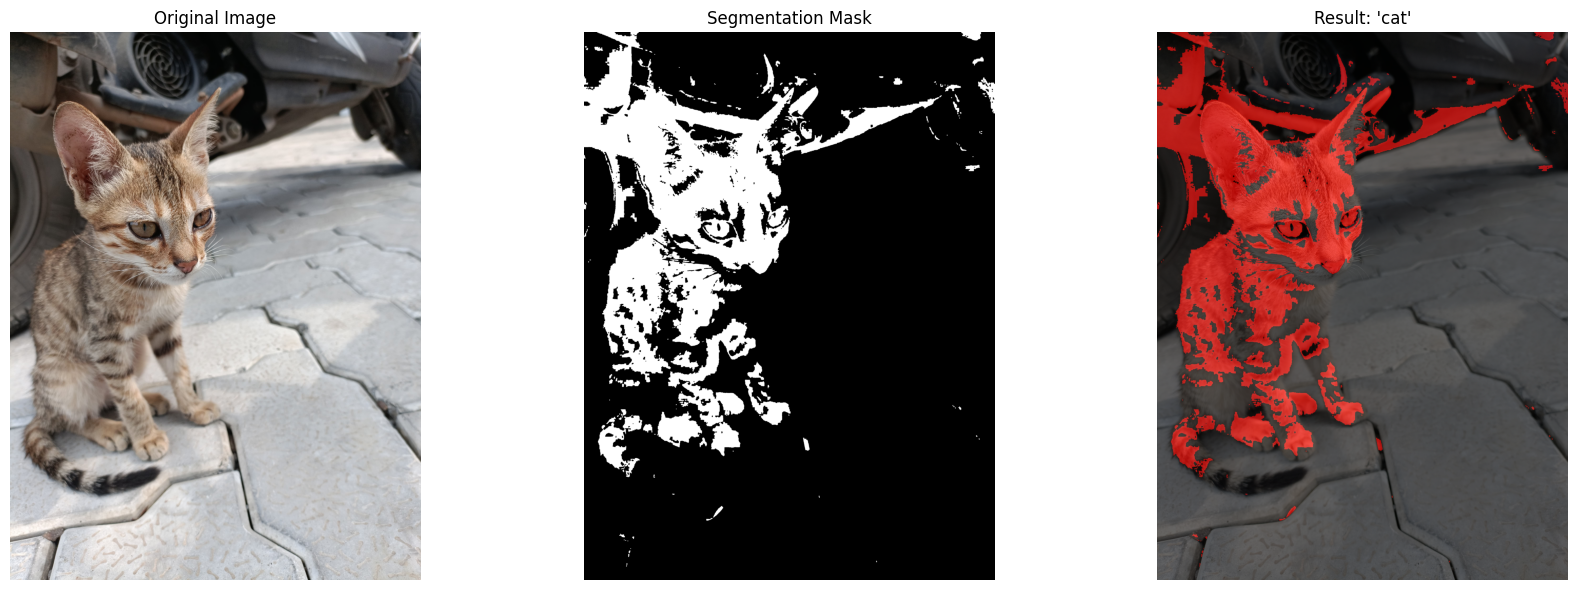

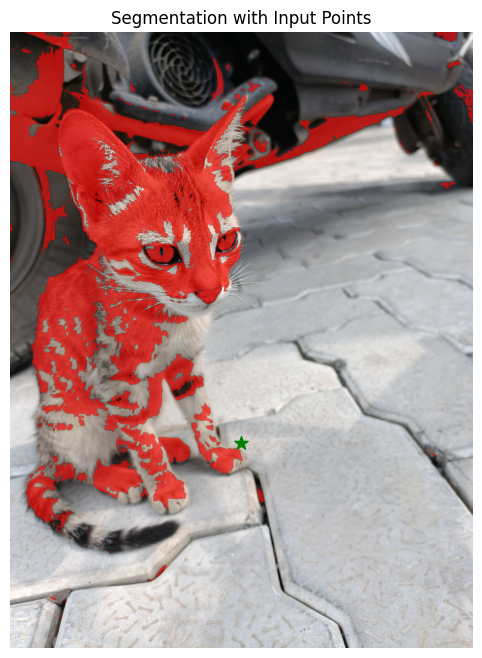

In [22]:
text_prompt = "cat"
result_mask, result_points = text_driven_segmentation(input_image, text_prompt)